# Sentiment Analysis with Deep Learning using BERT

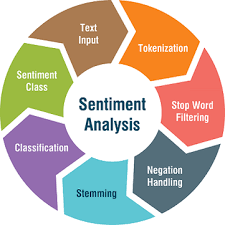

Bidirectional Representation for Transformers, or BERT, is a concept that was put up by Google AI language researchers in 2018. Although its primary goal was to enhance the comprehension of the meaning of Google Search queries, BERT has since emerged as one of the most significant and complete architectures for a variety of natural language tasks, producing cutting-edge results on tasks like classifying sentence pairs and question-answer sets, among others. One of BERT's key characteristics is its flexibility, which enables it to execute many NLP jobs with cutting-edge accuracy (similar to the transfer learning used in Computer vision).

In this notebook, we will be using the Pytorch BERT model of deep learning to perform Multi-class sentiment classification of tweets.

The dataset being used is available on https://www.kaggle.com/datasets/ashkhagan/smile-twitter-emotion-dataset.

## Exploratory Data Analysis and Preprocessing

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [19]:
df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')

In [20]:
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive


In [21]:
df.dropna(inplace=True)

In [22]:
df['category']=df['Sentiment']

In [23]:
df.category.value_counts()

Positive              9110
Negative              7763
Neutral               6172
Extremely Positive    5273
Extremely Negative    4249
Name: category, dtype: int64

In [24]:
possible_labels = df.category.unique()

In [25]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [26]:
df['label'] = df.category.replace(label_dict)

In [27]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,category,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive,1
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,Positive,1
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,Positive,1


## Training/Validation Split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_val, y_train, y_val = train_test_split(df.OriginalTweet.values, df.label.values, test_size = 0.15, random_state=17, stratify = df.label.values)

In [30]:
df['data_type'] = ['not_set']*df.shape[0]

In [31]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,category,label,data_type
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral,0,not_set
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,1,not_set
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive,1,not_set
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,Positive,1,not_set
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,Positive,1,not_set


In [34]:
df.groupby(['category', 'label', 'data_type']).count()

,,,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
category,label,data_type,,,,,,
Extremely Negative,4,,4249,4249,4249,4249,4249,4249
Extremely Positive,3,,5273,5273,5273,5273,5273,5273
Negative,2,,7763,7763,7763,7763,7763,7763
Neutral,0,,6172,6172,6172,6172,6172,6172
Positive,1,,9110,9110,9110,9110,9110,9110


##  Loading Tokenizer and Encoding our Data

In [35]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [36]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [39]:
X_train

array(['If I were @GovAbbott I\'d contact @everly_well to get bulk prices on #Covid_19 test kits and work faster to figure out the real picture here in Texas.  #texas has the nation\'s largest "rainy day fund." It\'s pouring outside in case you hadn\'t noticed! ??????',
       "Are you heading out to the grocery store for some items? Don't forget to clean your car during this #CoronavirusPandemic . Cash Cars Buyer offers the following tips: https://t.co/jEZ0yol7TB #WashYourHands #Covid_19 https://t.co/aPnUxVltwy",
       'What have you said today that youÂ\x92d never have said a month ago? \r\r\n\r\r\nMe: The queue to get into the supermarket only took me half an hour.\r\r\n\r\r\n#ThursdayThoughts #COVID19Pandemic \r\r\n#StayHomeSaveLives \r\r\n#lockdownuk',
       ...,
       "So I'm putting flavoured sparkling water in my gin, due to no tonic water of any description at the supermarket. Thanks a lot panic buyers.\r\r\n\r\r\n#Covid_19 #panicbuying #FirstWorldProblems",
       'Just po

In [41]:
encoded_data_train = tokenizer.batch_encode_plus(X_train,add_special_tokens=True,return_attention_mask=True,pad_to_max_length=True,max_length=256,return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [42]:
encoded_data_val= tokenizer.batch_encode_plus(X_val,add_special_tokens=True,return_attention_mask=True,pad_to_max_length=True,max_length=256,return_tensors='pt')

In [43]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

In [44]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val= encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

In [45]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [46]:
len(dataset_train)

27681

In [47]:
len(dataset_val)

4886

##  Setting up BERT Pretrained Model

In [48]:
from transformers import BertForSequenceClassification

In [49]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(label_dict), output_attentions=False,output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

##  Creating Data Loaders

In [50]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [51]:
batch_size = 32 #32

dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train),batch_size=batch_size)

In [52]:

dataloader_val = DataLoader(dataset_val,sampler=RandomSampler(dataset_val),batch_size=32)

##  Setting Up Optimizer and Scheduler

In [53]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [54]:
optimizer = AdamW(model.parameters(),lr=1e-5, #2e-5 > 5e-5 
                 eps=1e-8)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [64]:
epochs=2

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=len(dataloader_train)*epochs)

##  Defining our Performance Metrics

In [65]:
import numpy as np

In [66]:
from sklearn.metrics import f1_score

In [67]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [68]:
def accuracy_per_class(preds, labels):
    labels_dict_inverse = {v: k for k,v in label_dict.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {labels_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [69]:
import random

seed_val = 8
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [71]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar =  tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch),leave=False,disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
            
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch))})
        
    #torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/866 [00:00<?, ?it/s]

##  Loading and Evaluating our Model

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)

In [ ]:
accuracy_per_class(predictions, true_vals )